# Modeling

## Setup

In [61]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from pathlib import Path
import pandas as pd
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from helpers import *

## Load data

In [2]:
df = pd.read_parquet(ROOT_PATH/"data/interim/train.parquet")

In [3]:
df.shape

(463715, 91)

## Specify types

In [4]:
df.year = df.year.astype("category")

In [5]:
df.year.nunique()

89

In [6]:
df.dtypes

year             category
timbre_avg_1      float64
timbre_avg_2      float64
timbre_avg_3      float64
timbre_avg_4      float64
                   ...   
timbre_cov_74     float64
timbre_cov_75     float64
timbre_cov_76     float64
timbre_cov_77     float64
timbre_cov_78     float64
Length: 91, dtype: object

## Preprocessing

In [7]:
RANDOM_STATE=1337
N_JOBS=-1

In [8]:
cont_feat, cat_feat = cont_cat_split(df, dep_var="year")

In [9]:
print(len(cont_feat), len(cat_feat))

90 0


In [10]:
splits = RandomSplitter(valid_pct=0.1, seed=RANDOM_STATE)(range_of(df))

In [11]:
to = TabularPandas(df=df, procs=[Normalize], cat_names=cat_feat, cont_names=cont_feat, y_names="year", splits=splits)

In [12]:
len(to.train)

417344

In [13]:
len(to.valid)

46371

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

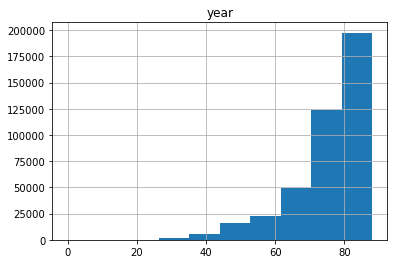

In [14]:
to.train.ys.hist()

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

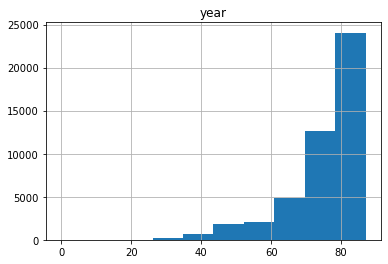

In [15]:
to.valid.ys.hist()

In [16]:
dls = to.dataloaders(bs=1024)

In [17]:
X_train, y_train = to.train.xs, to.train.y
X_valid, y_valid = to.valid.xs, to.valid.y

### Neural Net

In [30]:
learn = tabular_learner(dls, layers=[500, 250], metrics=[accuracy], )

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.002511886414140463)

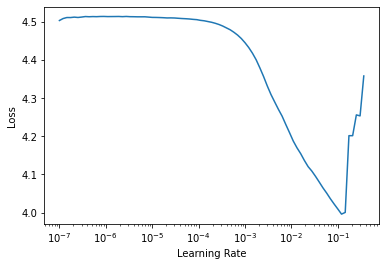

In [31]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(5, 0.01, cbs=[EarlyStoppingCallback(min_delta=0.1, patience=2)], wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.021283,3.067870,0.101141,00:18
1,3.039117,3.048825,0.101701,00:18
2,3.005297,3.026479,0.105605,00:18


No improvement since epoch 0: early stopping


In [36]:
learn.show_results()

,timbre_avg_1,timbre_avg_2,timbre_avg_3,timbre_avg_4,timbre_avg_5,timbre_avg_6,timbre_avg_7,timbre_avg_8,timbre_avg_9,timbre_avg_10,timbre_avg_11,timbre_avg_12,timbre_cov_1,timbre_cov_2,timbre_cov_3,timbre_cov_4,timbre_cov_5,timbre_cov_6,timbre_cov_7,timbre_cov_8,timbre_cov_9,timbre_cov_10,timbre_cov_11,timbre_cov_12,timbre_cov_13,timbre_cov_14,timbre_cov_15,timbre_cov_16,timbre_cov_17,timbre_cov_18,timbre_cov_19,timbre_cov_20,timbre_cov_21,timbre_cov_22,timbre_cov_23,timbre_cov_24,timbre_cov_25,timbre_cov_26,timbre_cov_27,timbre_cov_28,timbre_cov_29,timbre_cov_30,timbre_cov_31,timbre_cov_32,timbre_cov_33,timbre_cov_34,timbre_cov_35,timbre_cov_36,timbre_cov_37,timbre_cov_38,timbre_cov_39,timbre_cov_40,timbre_cov_41,timbre_cov_42,timbre_cov_43,timbre_cov_44,timbre_cov_45,timbre_cov_46,timbre_cov_47,timbre_cov_48,timbre_cov_49,timbre_cov_50,timbre_cov_51,timbre_cov_52,timbre_cov_53,timbre_cov_54,timbre_cov_55,timbre_cov_56,timbre_cov_57,timbre_cov_58,timbre_cov_59,timbre_cov_60,timbre_cov_61,timbre_cov_62,timbre_cov_63,timbre_cov_64,timbre_cov_65,timbre_cov_66,timbre_cov_67,timbre_cov_68,timbre_cov_69,timbre_cov_70,timbre_cov_71,timbre_cov_72,timbre_cov_73,timbre_cov_74,timbre_cov_75,timbre_cov_76,timbre_cov_77,timbre_cov_78,year,year_pred
0,0.992033,0.575151,0.944012,0.266232,0.001062,-0.397006,0.603415,0.528031,1.307238,1.257235,-0.365515,-0.416879,-0.360074,0.644755,-0.017507,-0.557084,-0.208251,0.033533,-0.009260,-0.492585,-0.194256,-0.465722,0.021900,-0.415133,1.127865,-0.543867,0.160732,0.034678,0.931017,-0.773215,0.302523,0.031182,-0.001309,-1.102030,0.197597,-0.392502,-0.834605,0.079198,-0.019826,-0.344626,0.138219,1.019294,0.724437,0.186531,0.319307,-0.560837,-0.957010,-0.711194,-0.468082,0.119083,-2.035316,0.989434,-1.526668,-0.171182,-0.319231,-0.987652,-0.001011,0.031675,-0.111405,0.516110,-0.404613,-0.222118,-1.528264,1.542690,-0.224315,0.385956,0.036350,-0.674814,-0.124789,1.040551,0.906653,0.721542,-0.421780,0.042392,-0.065874,0.379132,0.113483,-0.372110,0.448197,0.070942,0.389219,2.033201,0.268189,0.096917,0.699611,-1.640760,0.300542,-0.345074,-0.082095,-0.032260,84.0,84.0
1,-0.048229,-0.271909,-0.060225,-1.549389,0.036366,0.407591,-1.881513,-0.229813,0.089559,-0.404371,-0.552386,2.020885,-0.639583,-0.609775,-0.793545,0.022445,0.066330,-0.630866,-0.879644,-0.387433,-0.182353,-0.527034,-0.267147,-0.644132,-0.335597,-0.125121,-0.092813,0.619910,-0.012952,0.353175,-0.370281,0.104389,0.605303,-0.139509,-0.134990,-0.036800,0.327792,-0.232470,-0.785050,0.787447,-0.521058,-0.335971,0.443413,1.127163,1.176564,0.173354,-0.716775,-0.290031,-0.656308,0.637983,-1.101847,0.455650,0.043521,0.719961,0.243064,-0.459439,-0.413224,0.449379,0.119481,0.619445,-0.000976,-0.281909,0.243111,-0.116951,0.251054,0.837747,0.487896,-1.400463,0.365109,-0.640307,-0.307150,0.566574,-0.471979,-0.755158,0.181304,0.566069,-0.391158,0.614805,-0.217439,0.687915,-0.054877,-0.782656,0.296059,-0.025373,0.106677,-0.188040,0.228050,-0.572094,-0.458970,-0.117254,54.0,83.0
2,-0.182565,0.637238,-0.479725,0.139444,0.193971,1.408481,0.309838,0.126282,1.232553,1.192415,-1.377182,-0.575375,0.066786,1.100362,0.642748,1.434575,0.770701,0.675493,1.530524,2.133713,0.711277,1.429112,1.312505,0.852532,1.106827,-0.947951,0.332042,0.571189,-0.631384,0.143606,1.559765,2.294275,-1.071794,-1.664824,-1.356061,-1.176681,-0.916957,1.111362,-1.491925,1.679726,-0.368432,1.740015,-2.788204,1.939449,2.451622,0.345704,-1.072431,-0.094397,1.010513,0.947846,-0.314336,-0.502483,4.467475,-0.343972,-1.240044,-1.432102,1.746361,-1.620953,0.652410,-0.499946,0.095895,-0.613261,0.004159,-0.465511,1.764029,-0.684045,0.176985,0.293507,1.219224,-1.452947,0.606313,0.430546,0.519211,-1.585204,-0.302031,0.378769,-0.957486,0.084147,-2.585380,0.446490,-0.559713,-0.814099,0.065901,2.746960,0.315877,3.130524,1.303951,0.983406,-0.120312,0.283264,75.0,84.0
3,0.594890,0.269968,-0.919813,-1.078484,0.098428,-0.434421,0.322524,-0.641639,-0.507210,-0.988218,-0.357329,0.080775,0.717611,-0.255065,0.480663,

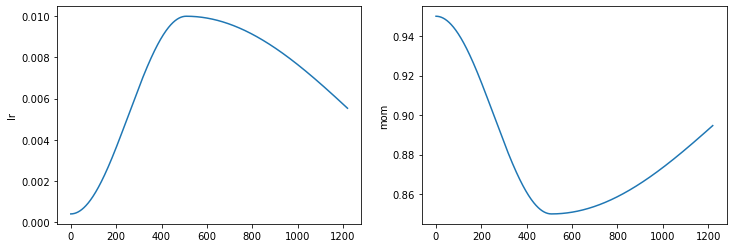

In [40]:
learn.recorder.plot_sched()

In [27]:
learn.export(ROOT_PATH/"models/tabular_net.pkl")

### Random Forrest

Apply best practices from fastai book, i.e. setting max_samples to *200.000* if dealing with more than 200.000 samples

In [17]:
rf_model = RandomForestClassifier(n_estimators=10, 
                                  max_samples=200_000, 
                                  max_features=0.5, 
                                  min_samples_leaf=4, 
                                  oob_score=True,
                                  n_jobs=N_JOBS, 
                                  random_state=RANDOM_STATE)

In [18]:
rf_model.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(max_features=0.5, max_samples=200000, min_samples_leaf=4,
                       n_estimators=10, n_jobs=-1, oob_score=True,
                       random_state=1337)

In [19]:
y_pred_valid = rf_model.predict(X_valid)

In [24]:
accuracy_score(y_valid, y_pred_valid)

0.08816837928468994